## Предсказание цены акции по экономическим новостям

Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [1]:
from tqdm import tqdm_notebook
import matplotlib as plt

In [2]:
import seaborn as sns

In [3]:
import pandas as pd
df = pd.read_csv('texts.csv')
df = df[df.text != ' '] # уберем пустые записи

In [4]:
df.head(3)

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...


In [5]:
pr_all = pd.read_csv('gazprom_prices.csv', sep=';')
pr_all.columns = pr_all.columns.str.lower()
pr_all.date = pd.to_datetime(pr_all.date, format='%d.%m.%Y')
print( pr_all.date.min(), ' ', pr_all.date.max())

2010-01-11 00:00:00   2017-12-08 00:00:00


In [6]:
# создадим df с ежедневными датами в выбранном диапазоне
date_full = pd.date_range(pr_all.date.min(), pr_all.date.max(), freq='D')

In [7]:
pr_full = pd.DataFrame(date_full.sort_values(ascending = False), columns=['date'])

In [8]:
pr_full = pd.merge(pr_full, pr_all[['date', 'closingprice']], how='left', on='date')

 Известно, что если в какой-либо день не было торгов, то используется цена закрытия предыдущего дня. Позволим себе сделать такое же приближение в этой задаче. Для этого создала таблицу, в которой есть дата каждого дня, соединила с известными данными торгов. NaNы заполним с помощью функции fillna и метода backfill. 

In [9]:
pr_full.closingprice.fillna(method = 'bfill', inplace = True)

In [10]:
pr_full.head(15)

,date,closingprice
0,2017-12-08,"132,60000"
1,2017-12-07,"133,02000"
2,2017-12-06,"134,00000"
3,2017-12-05,"133,65000"
4,2017-12-04,"133,77000"
5,2017-12-03,"133,02000"
6,2017-12-02,"133,02000"
7,2017-12-01,"133,02000"
8,2017-11-30,"132,15000"
9,2017-11-29,"133,55000"


In [11]:
# описание заданя оставила для удобства работы

### Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* О каких санкциях пишут в статьях?

In [12]:
import re
from nltk.tokenize import sent_tokenize

from nltk.corpus import stopwords
import pymorphy2 

m = pymorphy2.MorphAnalyzer() 

# Токенизация
# - убрала дефисы, тк в некоторых словах опечатки, оставила латиницу, тк несущие смысл слова
def tokenize(x):
    article = re.compile('[А-Яа-яA-Za-z]+')    
    return article.findall(x.lower())

In [13]:
# функция удаления дублирования строк текста(пример df.text.iloc[7], df.text.iloc[100])
def del_doubles(x):
    s_list = []
    sents = sent_tokenize(x)
    for i in sents: 
        s = str(' '.join(tokenize(i)))
        s_list.append(s)    
    return set(s_list)

In [143]:
df.text.iloc[7]

' «Газпром нефть», пробурившая первую скважину на Аяшском участке шельфа Сахалина, обнаружила крупное месторождение. Геологические запасы оценены в 255\xa0млн тонн, извлекаемые — в 70–80\xa0млн тонн, но эксперты осторожно замечают, что об экономической эффективности пока говорить рано. Предположительно, нефтекомпания будет искать партнера в проект, чтобы разделить риски. По словам источников “Ъ”, участком интересовалась Shell, но из-за санкций иностранцы с 2014 года на шельф России пока не идут.\r\n «Газпром нефть», пробурившая первую скважину на Аяшском участке шельфа Сахалина, обнаружила крупное месторождение. Геологические запасы оценены в 255\xa0млн тонн, извлекаемые — в 70–80\xa0млн тонн, но эксперты осторожно замечают, что об экономической эффективности пока говорить рано. Предположительно, нефтекомпания будет искать партнера в проект, чтобы разделить риски. По словам источников “Ъ”, участком интересовалась Shell, но из-за санкций иностранцы с 2014 года на шельф России пока не ид

In [14]:
%%time
df['text_dbl'] = df.text.apply(del_doubles)

Wall time: 516 ms


In [15]:
df['text_len'] = df.text_dbl.apply(lambda x: len(str(x))) # 

In [16]:
df['tokens'] = df.text_dbl.apply(lambda x: tokenize(str(x)))

In [17]:
# уберем стоп-слова из токенов, лемм

In [18]:
# часть стоп слов получена в результате анализа лемм, токенов, биграмм. Добавлялись в процессе анализа
mystopwords = stopwords.words('russian') + ['руб','млрд','млн','г','миллиард','рубль','сей','пора']

def stop_words(x):
    return [token for token in x if not token in mystopwords]

In [19]:
%%time
df['tokens_sw'] = df.tokens.apply(stop_words)

Wall time: 200 ms


In [20]:
df['tokens_len_word'] = df.tokens_sw.apply(len) # длина текста в словах
df['tokens_len_letter'] = df.tokens_sw.apply(lambda x: len(' '.join(x))) # длина текста в символах

In [21]:
# лемматизация

In [22]:
def lemm(x):
    text_lemma = [m.parse(word)[0].normal_form for word in x]
    return text_lemma

In [23]:
%%time
df['lemma'] = df.tokens.apply(lemm)

Wall time: 26.4 s


In [24]:
%%time
df['lemma_sw'] = df.lemma.apply(stop_words)

Wall time: 200 ms


In [25]:
df['lemm_len_word'] = df.lemma_sw.apply(len) # длина текста в словах
df['lemm_len_letter'] = df.lemma_sw.apply(lambda x: len(' '.join(x))) # длина текста в символах

In [26]:
# функция находит количество упоминаний токена по паттерну
def miller(pattern, x):
    res = []
    res = re.findall(pattern,x.lower())
    return len(res)

In [27]:
#s = ' милер милерами сделали хорошее предложение согласился миллера'
pattern = r'мил.?ер+[a-я]{0,3}'

In [28]:
df['miller'] = df.text.apply(lambda x: miller(pattern, x))
#df.miller.value_counts()

# Упоминание газопроводов

In [29]:
# северный поток
north_pattern = r'северн+[а-я]{0,3}\s+поток+[а-я]{0,3}'
eng_nord_pattern = r'nord.?stream'

In [30]:
df['north'] = df.text.apply(lambda x: miller(north_pattern, x))
df.north.sum()

15

In [31]:
df['eng_nord'] = df.text.apply(lambda x: miller(eng_nord_pattern, x))
df.eng_nord.sum()

80

In [32]:
nord_str = df.north.sum() + df.eng_nord.sum()
nord_str

95

Итого "северный поток" упоминается в статьях 95 раз

In [33]:
# турецкий поток
turkish_pattern = r'турецк+[а-я]{0,3}\s+поток+[а-я]{0,3}'
eng_turkish_pattern = r'turkish.?stream'

In [34]:
df['turkish'] = df.text.apply(lambda x: miller(turkish_pattern, x))
df.turkish.sum()

39

In [35]:
df['eng_turkish'] = df.text.apply(lambda x: miller(eng_turkish_pattern, x))
df.eng_turkish.sum()

0

In [36]:
turk_stream = df.turkish.sum() + df.eng_turkish.sum()
turk_stream

39

Итого "турецкий поток" употребляется в статьях 39 раз.

# Корелляция

In [37]:
# проследим, наблюдается ли корелляция длины текста (необработанного, в леммах, токенах) и цены закрытия

In [38]:
df.date = pd.to_datetime(df.date, format='%d.%m.%Y')

In [39]:
txt_pr = pd.merge(pr_full, df, how = 'right', left_on= 'date', right_on= 'date')

In [40]:
txt_pr.closingprice = pd.to_numeric(txt_pr.closingprice.str.replace(',','.'))

In [41]:
txt_pr.corr(method = 'pearson')

,closingprice,text_len,tokens_len_word,tokens_len_letter,lemm_len_word,lemm_len_letter,miller,north,eng_nord,turkish,eng_turkish
closingprice,1.000000,-0.022378,-0.023119,-0.021083,-0.021582,-0.020471,0.010802,0.035337,-0.010322,-0.059740,NaN
text_len,-0.022378,1.000000,0.996960,0.998119,0.996817,0.998147,0.207409,0.088838,0.087613,0.088523,NaN
tokens_len_word,-0.023119,0.996960,1.000000,0.997102,0.999071,0.996813,0.209061,0.088126,0.091079,0.090625,NaN
tokens_len_letter,-0.021083,0.998119,0.997102,1.000000,0.996126,0.999328,0.210129,0.086244,0.085834,0.085984,NaN
lemm_len_word,-0.021582,0.996817,0.999071,0.996126,1.000000,0.997123,0.212704,0.088557,0.087386,0.086691,NaN
lemm_len_letter,-0.020471,0.998147,0.996813,0.999328,0.997123,1.000000,0.212413,0.086609,0.083302,0.083626,NaN
miller,0.010802,0.207409,0.209061,0.210129,0.212704,0.212413,1.000000,0.161801,0.053370,-0.016198,NaN
north,0.035337,0.088838,0.088126,0.086244,0.088557,0.086609,0.161801,1.000000,0.209681,0.076162,NaN
eng_nord,-0.010322,0.087613,0.091079,0.085834,0.087386,0.083302,0.053370,0.209681,1.000000,0.137084,NaN
turkish,-0.059740,0.088523,0.090625,0.085984,0.086691,0.083626,-0.016198,0.076162,0.137084,1.000000,NaN


Корелляция между длиной текста и ценой закрытия не наблюдается. Оцениваем по первой строке и столбцам с суффиксом '_len'

In [42]:
# выделим отдельно DF, в котором будут данные о цене закрытия и числом умпоминайний имени "Алексей Миллер"

In [43]:
df_miller = txt_pr[['closingprice', 'miller']][txt_pr.miller > 0]

In [44]:
df_miller.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 40 to 1200
Data columns (total 2 columns):
closingprice    102 non-null float64
miller          102 non-null int64
dtypes: float64(1), int64(1)
memory usage: 2.4 KB


In [45]:
df_miller.corr(method = 'pearson')

,closingprice,miller
closingprice,1.000000,0.056183
miller,0.056183,1.000000


Корелляция между числом упоминаний 'Алексей Миллер' и ценой закрытия не наблюдается.

# Упоминание санкций

In [46]:
sanction = r'санкц+[а-я]{0,5}\s'

In [47]:
df['sanct'] = df.text.apply(lambda x: miller(sanction, x))

In [48]:
df.sanct.sum()

47

In [49]:
df_sanct = df[df.sanct > 0]

In [50]:
df_sanct.reset_index(inplace= True)

In [51]:
#del df_sanct['index']

In [52]:
import nltk
from nltk.collocations import *
N_best = 200

In [53]:
tokens_for_sanct = []
for i in range(len(df_sanct)):
    tokens_for_sanct.extend(df_sanct.lemma_sw.iloc[i])

Найдем связные с санкциями биграмы и триграмы

In [54]:
bigram_measures = nltk.collocations.BigramAssocMeasures() # класс для мер ассоциации биграм
finder = BigramCollocationFinder.from_words(tokens_for_sanct) # класс для хранения и извлечения биграм

In [55]:
finder.apply_freq_filter(3) # избавимся от биграм, которые встречаются реже трех раз

In [56]:
raw_freq_ranking = [' '.join(i) for i in finder.nbest(bigram_measures.raw_freq, N_best)] # выбираем топ-10 биграм по частоте 
tscore_ranking = [' '.join(i) for i in finder.nbest(bigram_measures.student_t, N_best)] # выбираем топ-100 бигра по каждой мере 
pmi_ranking =  [' '.join(i) for i in finder.nbest(bigram_measures.pmi, N_best)]
llr_ranking = [' '.join(i) for i in finder.nbest(bigram_measures.likelihood_ratio, N_best)]
chi2_ranking =  [' '.join(i) for i in finder.nbest(bigram_measures.chi_sq, N_best)]

In [57]:
rankings = pd.DataFrame({ 'chi2': chi2_ranking, 'llr':llr_ranking, 't_score' : tscore_ranking, 'pmi': pmi_ranking, 'raw_freq':raw_freq_ranking})
rankings = rankings[['raw_freq', 'pmi', 't_score', 'chi2', 'llr']]
rankings.head(5)

,raw_freq,pmi,t_score,chi2,llr
0,газпром нефть,ангнуть голландский,газпром нефть,ангнуть голландский,газпром нефть
1,российский компания,чёрный список,российский компания,топ менеджер,топ менеджер
2,данные ъ,nord stream,данные ъ,чистый прибыль,первое полугодие
3,алексей миллер,кредитный линия,топ менеджер,чёрный список,алексей миллер
4,газа год,чистый прибыль,первое полугодие,первое полугодие,данные ъ


In [58]:
rankings.raw_freq[rankings.raw_freq.str.contains('санкция') == True]

17    западный санкция
21        санкция мочь
22      санкция против
23         санкция сша
55    штрафной санкция
Name: raw_freq, dtype: object

In [59]:
rankings.pmi[rankings.pmi.str.contains('санкция') == True]

29    штрафной санкция
31      санкция против
40         санкция сша
43    западный санкция
52        санкция мочь
Name: pmi, dtype: object

In [60]:
rankings.t_score[rankings.t_score.str.contains('санкция') == True]

19      санкция против
20         санкция сша
21    западный санкция
24        санкция мочь
43    штрафной санкция
Name: t_score, dtype: object

In [61]:
rankings.chi2[rankings.chi2.str.contains('санкция') == True]

29      санкция против
32    штрафной санкция
39         санкция сша
44    западный санкция
52        санкция мочь
Name: chi2, dtype: object

In [62]:
rankings.llr[rankings.llr.str.contains('санкция') == True]

26      санкция против
34    штрафной санкция
37         санкция сша
43    западный санкция
52        санкция мочь
Name: llr, dtype: object

Как видно, санкции упоминаются в контексте: штрафные, западные, санкции; санкции сша; санкции против (газпрома *мое примечание)

In [63]:
N_best = 300

In [64]:
trigram_measures = nltk.collocations.TrigramAssocMeasures # класс для мер ассоциации триграмм

In [65]:
trigram_finder = TrigramCollocationFinder.from_words(tokens_for_sanct)

In [66]:
raw_freq_ranking_tr = [' '.join(i) for i in trigram_finder.nbest(trigram_measures.raw_freq, N_best)] # выбираем топ-100 биграм по частоте 
tscore_ranking_tr = [' '.join(i) for i in trigram_finder.nbest(trigram_measures.student_t, N_best)] # выбираем топ-100 биграм по каждой мере 
pmi_ranking_tr =  [' '.join(i) for i in trigram_finder.nbest(trigram_measures.pmi, N_best)]
llr_ranking_tr = [' '.join(i) for i in trigram_finder.nbest(trigram_measures.likelihood_ratio, N_best)]
chi2_ranking_tr =  [' '.join(i) for i in trigram_finder.nbest(trigram_measures.chi_sq, N_best)]

In [67]:
rankings_tr = pd.DataFrame({ 'chi2': chi2_ranking_tr, 'llr':llr_ranking_tr, 't_score' : tscore_ranking_tr, 'pmi': pmi_ranking_tr, 'raw_freq':raw_freq_ranking_tr})
rankings_tr = rankings_tr[['raw_freq', 'pmi', 't_score', 'chi2', 'llr']]
rankings_tr.head(3)

,raw_freq,pmi,t_score,chi2,llr
0,стать известно ъ,central asia ag,стать известно ъ,central asia ag,газпром нефть планировать
1,ангнуть голландский shell,ictv понедельник вечером,ангнуть голландский shell,ictv понедельник вечером,лукойл газпром нефть
2,западный рынок капитал,naftna industrija srbija,западный рынок капитал,naftna industrija srbija,shell газпром нефть


In [68]:
rankings_tr.raw_freq[rankings_tr.raw_freq.str.contains('санкция') == True]

32                      санкция сша ес
88            shell санкция иностранец
152       американский санкция ставить
153            анализ ситуация санкция
196           банка санкция территория
223    введение санкция предоставление
224            введение санкция против
228            ввести санкция компания
255         визовый финансовый санкция
258              виток санкция сторона
274            влияние санкция считать
275         влияние санкция финансовый
287      возможный последствие санкция
294             волна санкция объявить
295      волна санкция проигнорировать
299           вопрос поскольку санкция
Name: raw_freq, dtype: object

In [69]:
rankings_tr.t_score[rankings_tr.t_score.str.contains('санкция') == True]

34    санкция сша ес
Name: t_score, dtype: object

In [70]:
rankings_tr.llr[rankings_tr.llr.str.contains('санкция') == True]

103         западный санкция против
185         введение санкция против
233    существенный влияние санкция
249       институт развитие санкция
274             попасть санкция сша
283                  санкция сша ес
Name: llr, dtype: object

Триграммы дают большую ясность об упоминании санкций. Это: санкции сша и ес; западные, американские, шрафные, визовые и финансовые. Упоминается волна введенных санкций, рассматривается их влияние и последствия. Введение санкций к газовым корпорациям.

Данные по t_score и llr не дали информации.

In [71]:
# задание оставлено для удобства работы

## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [72]:
txt_pr['closingprice_bin'] = 0

In [73]:
# бинаризируем
for i in tqdm_notebook( range(1201, 0, -1)):
    #print(i ,   txt_pr.closingprice.iloc[i-1],txt_pr.closingprice.iloc[i] )
    if txt_pr.closingprice.iloc[i-1] > txt_pr.closingprice.iloc[i]:
        txt_pr.closingprice_bin.iloc[i-1] = 1

A Jupyter Widget

C:\Users\blacat\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [74]:
txt_pr[['date','closingprice','closingprice_bin']].head(6)

,date,closingprice,closingprice_bin
0,2017-11-09,131.50,0
1,2017-11-08,132.30,1
2,2017-11-01,126.50,1
3,2017-10-30,125.98,0
4,2017-10-23,126.80,1
5,2017-10-20,126.70,0


In [75]:
train = txt_pr[txt_pr.date < pd.to_datetime('2016-1-1')]

In [76]:
test = txt_pr[txt_pr.date > pd.to_datetime('2015-12-31')]

In [77]:
def text(x):
    a = ' '.join(x)
    #print(a)
    return a 

In [79]:
# введем числовые признаки и создадим классификаторы на основе
# CountVectorizer, tf-idf с логистическоей регрессией, наимвным байесом, подберем лучшие параметры

In [80]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [81]:
# разделим на тестовую и обучающие выборки

In [82]:
Xtrain = train[['closingprice_bin','closingprice','lemm_len_word','lemma_sw','tokens_sw','text_dbl']]

In [83]:
ytrain = train['closingprice_bin']

In [84]:
Xtest = test[['closingprice_bin','closingprice','lemm_len_word','lemma_sw','tokens_sw','text_dbl']]

In [85]:
ytest = test['closingprice_bin']

для классификаторов MultinomialNB(), LogisticRegression() подберем лучшие параметры, 
методов обработки текста и извлечению параметров и выберем наилучшее сочетание для классификации текста простейшими средствами

In [86]:
pipe_cv_nb = Pipeline([('vect', CountVectorizer() ),
                       ('tfidf', TfidfTransformer() ),
                       ('clf', MultinomialNB() )])
param_cv_nb = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),  # unigrams or bigrams and n-grams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.3, 0.5, 1.0, 10.0, 20.0,  50.0)}

In [87]:
grid_search = GridSearchCV(pipe_cv_nb, param_cv_nb, n_jobs=-1, verbose=5, scoring='accuracy')

In [88]:
%%time
grid_search.fit(Xtrain.tokens_sw.apply(text), ytrain)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.2min finished


Wall time: 3min 11s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.3, 0.5, 1.0, 10.0, 20.0, 50.0)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=5)

In [89]:
grid_search.best_score_

# text_dbl 0.53311965811965811
# tokens_sw 0.53418803418803418
# lemma_sw 0.53632478632478631

0.53418803418803418

Наилучшая точность классификации для лемм без стоп-слов, хотя точность классификации низкая.

In [102]:
pipe_cv_lr = Pipeline([('vect', CountVectorizer() ), 
                       ('tfidf', TfidfTransformer() ), 
                       ('clf', LogisticRegression() )])

param_cv_lr = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),  # unigrams or bigrams and n-grams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__penalty': ('l1','l2'),
    'clf__C' : (0.001, 0.01, 0.1, 1, 2, 5)
}

In [103]:
grid_search = GridSearchCV(pipe_cv_lr, param_cv_lr, n_jobs=-1, verbose=5, scoring='accuracy')

In [104]:
%%time
grid_search.fit(Xtrain.text_dbl.apply(text), ytrain)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  7.9min finished


Wall time: 7min 51s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__penalty': ('l1', 'l2'), 'clf__C': (0.001, 0.01, 0.1, 1, 2, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=5)

In [105]:
grid_search.best_score_

# text_dbl 0.56196581196581197
# tokens_sw 0.53525641025641024
# lemma_sw 0.54059829059829057

0.56196581196581197

Наилучшая точность классификации для текста без лемматизации и токенизации, хотя точность классификации низкая.

In [94]:
pipe_tdf_nb = Pipeline([('vect', TfidfVectorizer() ), 
                        ('clf', MultinomialNB() )])

param_tdf_nb = {
    'vect__max_df': (0.3, 0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),  # unigrams or bigrams and n-grams
    'clf__alpha': (0.3, 0.5, 0.7, 0.9, 1.0, 10.0, 20.0,  50.0)}

In [95]:
grid_search = GridSearchCV(pipe_tdf_nb, param_tdf_nb, n_jobs=-1, verbose=5, scoring='accuracy')

In [96]:
%%time
grid_search.fit(Xtrain.lemma_sw.apply(text), ytrain)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  1.3min finished


Wall time: 1min 20s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.3, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)), 'clf__alpha': (0.3, 0.5, 0.7, 0.9, 1.0, 10.0, 20.0, 50.0)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=5)

In [97]:
grid_search.best_score_

# text_dbl 0.53205128205128205
# tokens_sw 0.53205128205128205
# lemma_sw 0.53311965811965811

0.53418803418803418

Наилучшая точность классификации для текста c лемматизацией, хотя точность классификации низкая.

In [98]:
pipe_tdf_lr = Pipeline([('vect', TfidfVectorizer() ), 
                        ('clf', LogisticRegression() )])

param_tdf_lr = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),  # unigrams or bigrams and n-grams
    'clf__penalty': ('l1','l2'),
    'clf__C' : (0.001, 0.01, 0.1, 1, 2, 5)
}

In [99]:
grid_search = GridSearchCV(pipe_tdf_lr, param_tdf_lr, n_jobs=-1, verbose=5, scoring='accuracy')

In [100]:
%%time
grid_search.fit(Xtrain.lemma_sw.apply(text), ytrain)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.5min finished


Wall time: 1min 30s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)), 'clf__penalty': ('l1', 'l2'), 'clf__C': (0.001, 0.01, 0.1, 1, 2, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=5)

In [101]:
grid_search.best_score_

# text_dbl 0.56196581196581197
# tokens_sw 0.53205128205128205
# lemma_sw 0.53525641025641024

0.53846153846153844

Наиболее высокий результат классификации получен логистической регрессией, используем его. Характеристики извлечем CountVectorizer(). Используем лучшие параметры, которые дал gridsearch. n-граммы с числом слов больше 3 ухудшают качество предсказания.

In [106]:
grid_search.best_params_

{'clf__C': 1,
 'clf__penalty': 'l1',
 'tfidf__norm': 'l2',
 'tfidf__use_idf': False,
 'vect__max_df': 1.0,
 'vect__ngram_range': (1, 1)}

In [108]:
cvt = CountVectorizer(max_df = 1.0, ngram_range = (1, 1))

In [109]:
X_train = cvt.fit_transform(Xtrain.text_dbl.apply(text))

In [110]:
X_test = cvt.transform(Xtest.text_dbl.apply(text))

In [111]:
tfdf = TfidfTransformer(use_idf=False, norm= 'l2')

In [112]:
X_train = tfdf.fit_transform(X_train)
X_test = tfdf.transform(X_test)

In [113]:
X_test.shape

(266, 14587)

In [114]:
clf_lr = LogisticRegression(penalty='l1', C = 1.0).fit(X_train, ytrain)
predicted = clf_lr.predict(X_test)

In [115]:
predicted

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [124]:
acc = accuracy_score(predicted, ytest)
f1 = f1_score(predicted, ytest)
micro_f1 = f1_score(predicted, ytest, average = 'micro')
macro_f1 = f1_score(predicted, ytest, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('f1={0:1.4f}'. format(f1))
print('micro F1={0:1.4f}'.format(micro_f1))
print('macro F1={0:1.4f}\n'.format(macro_f1))

acc=0.5489
f1=0.3258
micro F1=0.5489
macro F1=0.4934



In [125]:
# heatmap

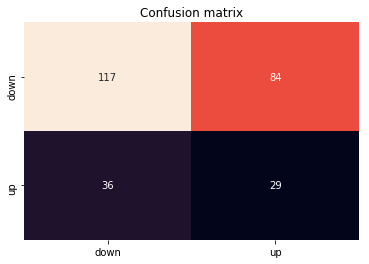

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(data=confusion_matrix(predicted,ytest), annot=True, fmt="d", cbar=False, xticklabels=['down','up'], yticklabels=['down','up'])
plt.title("Confusion matrix")
plt.show()

Нельзя сказать, что полученный классификатор хорошо предсказывает падение и повышение цены. 

## Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     

In [ ]:
# используем только существительные и скрытые темы вместе

In [134]:
# поиск существительных в тексте
def nouns(x):
    noun = set()
    for w in x:
        p = m.parse(w)[0].tag
        if 'NOUN' in p:
            noun.add(w)
    return noun

In [135]:
# найдем существительные в леммах и токенах, будем использовать их как признаки.

In [136]:
Xtrain['lemma_noun'] = Xtrain.lemma_sw.apply(nouns)

C:\Users\blacat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [137]:
Xtrain['tokens_noun'] = Xtrain.tokens_sw.apply(nouns)

C:\Users\blacat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [138]:
Xtest['lemma_noun'] = Xtest.lemma_sw.apply(nouns)
Xtest['tokens_noun'] = Xtest.tokens_sw.apply(nouns)

C:\Users\blacat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\blacat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [139]:
# используем tf-idf и наивный байес

In [140]:
pipe_tdf_nb = Pipeline([('vect', TfidfVectorizer() ), 
                        ('clf', MultinomialNB() )])

param_tdf_nb = {
    'vect__max_df': (0.3, 0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),  # unigrams or bigrams and n-grams
    'clf__alpha': (0.3, 0.5, 0.7, 0.9, 1.0, 10.0, 20.0,  50.0)}

In [141]:
grid_search = GridSearchCV(pipe_tdf_nb, param_tdf_nb, n_jobs=-1, verbose=5, scoring='accuracy')

In [144]:
# проверим, для каких существительных (токены, леммы) классификатор дает лучший результат

In [147]:
%%time
grid_search.fit(Xtrain.lemma_noun.apply(text), ytrain)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:   40.8s finished


Wall time: 41.4 s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.3, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)), 'clf__alpha': (0.3, 0.5, 0.7, 0.9, 1.0, 10.0, 20.0, 50.0)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=5)

In [149]:
grid_search.best_score_
# accuracy
# tokens_noun 0.53311965811965811
# lemma_noun 0.54700854700854706

0.54700854700854706

Выделение только существительных не дало прироста качества классификатора